In [125]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader
import wandb
from models.vgg19_model import get_vgg19_model
from models.vit_model import get_vit_model
from models.alexnet_model import get_alexnet_model
from models.gideon_alex_net import get_gideon_alexnet_model
from models.resnet_model import get_resnet_model, get_timm_model
from models.resnet_model import get_timm_model
from models.dino_model import get_dinov2_model
from torchvision import transforms
from preprocessing.clahe import CLAHETransform
from utils.logger import init_wandb
from collections import Counter
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from losses.label_smoothing import LabelSmoothingCrossEntropy
from losses.confidence_weighted_loss import ConfidenceWeightedCrossEntropy
from losses.combined_loss import CombinedLabelSmoothingConfidenceWeightedLoss

from utils.hard_sampling import get_low_confidence_samples
from utils.saver import save_test_outputs
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import KFold
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import KFold
from dataset_handler.dataset import ImageDataset
from preprocessing.clahe import CLAHETransform
import tqdm

In [126]:
import torch
import torch.nn as nn
from torchvision import models
import wandb
from collections import OrderedDict
import timm  # pip install timm


def get_timm_model(weights_path=None, name=None):
    """
    Returns model, feature_dim.
    name ∈ {"resnet34","resnet50","densenet121","efficientnet_b0"}
    """

    num_classes = wandb.config.NUM_CLASSES
    dropout = wandb.config.DROPOUT
    if name == None:
        name = wandb.config.MODEL_NAME
    if name == "resnet34":
        # Freeze all parameters initially
        model = models.resnet34(weights="ResNet34_Weights.DEFAULT")
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze layers in the last ResNet block (layer4) and the fully connected layers
        for param in model.layer4.parameters():
            param.requires_grad = True  
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(num_ftrs, 512)),
                    ("bn1", nn.BatchNorm1d(512)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout(dropout)),
                    ("fc2", nn.Linear(512, num_classes)),
                ]
            )
        )
        
    elif name == "resnet50":
        model = models.resnet50(weights="ResNet50_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze layers in the last ResNet block (layer4) and the fully connected layers
        for param in model.layer4.parameters():
            param.requires_grad = True 
        model.fc = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(num_ftrs, 1024)),
                    ("bn1", nn.BatchNorm1d(1024)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout(dropout)),
                    ("fc2", nn.Linear(1024, 512)),
                    ("bn2", nn.BatchNorm1d(512)),
                    ("relu2", nn.ReLU()),
                    ("dropout2", nn.Dropout(dropout)),
                    ("fc3", nn.Linear(512, num_classes)),
                ]
            )
        )

    elif name == "densenet121":
        model = models.densenet121(weights="DenseNet121_Weights.DEFAULT")
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(num_ftrs, 512)),
                    ("bn1", nn.BatchNorm1d(512)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout(dropout)),
                    ("fc2", nn.Linear(512, num_classes)),
                ]
            )
        )

    elif name == "efficientnet_b0" or name == "efficientnet":
        model = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=num_classes
        )

    else:
        raise ValueError("Unknown backbone")

    return model


def get_resnet_model(weights_path=None):

    model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

    # Freeze all parameters initially
    for parameter in model.parameters():
        parameter.requires_grad = False

    num_ftrs = model.fc.in_features
    classifier = nn.Sequential(
        OrderedDict(
            [
                ("fc1", nn.Linear(num_ftrs, 1024)),
                ("bn1", nn.BatchNorm1d(1024)),
                ("relu1", nn.ReLU()),
                ("dropout1", nn.Dropout(wandb.config.DROPOUT)),
                ("fc2", nn.Linear(1024, 512)),
                ("bn2", nn.BatchNorm1d(512)),
                ("relu2", nn.ReLU()),
                ("dropout2", nn.Dropout(wandb.config.DROPOUT)),
                ("fc3", nn.Linear(512, wandb.config.NUM_CLASSES)),
            ]
        )
    )
    model.fc = classifier

    for name, param in model.named_parameters():
        # Unfreeze layer4 and the classifier
        param.requires_grad = False
        for layer in wandb.config.RESNET_LAYERS_TO_TRAIN:
            if layer in name:
                param.requires_grad = True
    if weights_path:
        state_dict = torch.load(
            weights_path, map_location=wandb.config.DEVICE
        )  # or "cuda" if using GPU
        model.load_state_dict(state_dict)

    return model


In [127]:
def ensemble_test_predictions(models, test_dataset):
    loader = DataLoader(test_dataset, batch_size=32)
    all_probs = []
    true_labels = []
    filenames = []

    for images, labels, paths in loader:
        images = images.to("cuda")
        batch_probs = []

        for model in models:
            model.eval()
            with torch.no_grad():
                logits = model(images)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs.cpu())

        avg_probs = torch.stack(batch_probs).mean(dim=0)
        all_probs.append(avg_probs)
        true_labels.extend(labels.numpy())
        filenames.extend(paths)

    all_probs = torch.cat(all_probs).numpy()
    predicted_labels = np.argmax(all_probs, axis=1)
    return filenames, true_labels, predicted_labels, all_probs


def ensemble_weighted_probs(models, weights, test_dataset):
    assert len(models) == len(weights), "Number of weights must match number of models"
    loader = DataLoader(test_dataset, batch_size=32)
    all_probs = []
    true_labels = []
    filenames = []

    weights = torch.tensor(weights).view(-1, 1, 1)  # shape: (num_models, 1, 1)

    for images, labels, paths in loader:
        images = images.to("cuda")
        batch_probs = []

        for model in models:
            model.eval()
            with torch.no_grad():
                logits = model(images)
                probs = F.softmax(logits, dim=1)
                batch_probs.append(probs.cpu())

        # Weighted average of probabilities
        batch_probs = torch.stack(batch_probs)  # shape: (num_models, batch_size, num_classes)
        weighted_avg_probs = (batch_probs * weights).sum(dim=0) / weights.sum()
        
        all_probs.append(weighted_avg_probs)
        true_labels.extend(labels.numpy())
        filenames.extend(paths)

    all_probs = torch.cat(all_probs).numpy()
    predicted_labels = np.argmax(all_probs, axis=1)
    return filenames, true_labels, predicted_labels, all_probs


from collections import Counter

def ensemble_majority_vote(models, test_dataset):
    loader = DataLoader(test_dataset, batch_size=32)
    all_votes = []
    true_labels = []
    filenames = []

    for images, labels, paths in loader:
        images = images.to("cuda")
        batch_votes = []

        for model in models:
            model.eval()
            with torch.no_grad():
                logits = model(images)
                preds = torch.argmax(logits, dim=1)
                batch_votes.append(preds.cpu().numpy())

        # Majority vote for each sample
        batch_votes = np.stack(batch_votes, axis=1)  # shape: (batch_size, num_models)
        voted_preds = [Counter(row).most_common(1)[0][0] for row in batch_votes]

        all_votes.extend(voted_preds)
        true_labels.extend(labels.numpy())
        filenames.extend(paths)
    predicted_labels = np.argmax(all_votes, axis=1)
    return filenames, true_labels, predicted_labels, all_votes



In [128]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import numpy as np

# Your ensemble_test_predictions function goes here (already provided)

# Example model class — replace with your actual one
from torchvision.models import resnet50
from torch.nn import Linear

def create_model(num_classes):
    model = resnet50(pretrained=False)
    model.fc = Linear(model.fc.in_features, num_classes)
    return model

def load_models_from_folder(folder_path, num_classes, device="cuda"):
    model_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pth")]
    models = []

    for path in model_paths:
        print(path)
        model_class_name = os.path.split(path)[-1].split("_")[:1][0]
        if model_class_name=="ResNet50":
            model = get_resnet_model(path)
        else:
            model = get_timm_model(path,model_class_name)

        # model = create_model(num_classes)
        state_dict = torch.load(
            path, map_location=wandb.config.DEVICE
        )  # or "cuda" if using GPU
        model.load_state_dict(state_dict)

        # model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        models.append(model)

    return models


In [129]:
from argparse import Namespace


size = (512, 512) 
args = Namespace(LEARNING_RATE=7, BATCH_SIZE=32,NUM_CLASSES=3, NUM_EPOCHS=20, USE_CLAHE=False, MODEL_NAME='ResNet50', USE_OSTEOPENIA=True, USE_TEST_DATA_DIR=True, USE_SCHEDULER=True, TRAIN_WEIGHTED_RANDOM_SAMPLER=True, NUM_WORKERS=1, DATA_DIR='/data/final_version/train_data/cropped_by_yolo', TEST_DATA_DIR='data/final_version/test_data/cropped_by_yolo', USE_LABEL_SMOOTHING=True, USE_HARD_SAMPLING=False, USE_CONFIDENCE_WEIGHTED_LOSS=False, CONFIDENCE_PENALTY_WEIGHT=2.0, CONFIDENCE_THRESHOLD=0.85, LABEL_SMOOTHING_EPSILON=0.1, USE_TRANSFORM_AUGMENTATION_IN_TRAINING=True, FINE_TUNE_LR_MULTIPLIER=1.0, DROPOUT=0.5, RESNET_LAYERS_TO_TRAIN=['fc', 'layer2', 'layer3', 'layer4'])
init_wandb(project_name="models_for_ensemble", args=args)
prepare_to_network_transforms = [
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]


augmentation_transform = [
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small shifts
    transforms.ColorJitter(brightness=0.2, 
                        contrast=0.2, 
                        saturation=0.2, 
                        hue=0.1),  # Adjust contrast
]

all_transformation = []
train_transformations = []
train_transformations += augmentation_transform

all_transformation += prepare_to_network_transforms
train_transformations += all_transformation
eval_transform = transforms.Compose(all_transformation)

train_transform = transforms.Compose(train_transformations)



test_dataset = ImageDataset(wandb.config.TEST_DATA_DIR)
test_dataset.transform = eval_transform


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


ensemble_0_f1-score,▁
ensemble_0_precision,▁
ensemble_0_recall,▁
ensemble_0_support,▁
ensemble_1_f1-score,▁
ensemble_1_precision,▁
ensemble_1_recall,▁
ensemble_1_support,▁
ensemble_2_f1-score,▁
ensemble_2_precision,▁
ensemble_2_recall,▁


Wandb configuration:
DATA_DIR: /data/final_version/train_data/cropped_by_yolo
TEST_DATA_DIR: data/final_version/test_data/cropped_by_yolo
DUPLICATE_THRESHOLD: 0.99
YOLO_WEIGHTS_PATH: /workspace/osteoporosis_project/pretrained/yolo_weights.pt
DEVICE: cuda
BATCH_SIZE: 32
NUM_EPOCHS: 20
LEARNING_RATE: 7
ALEX_FREEZE_FEATURES: True
USE_TRANSFORM_AUGMENTATION_IN_TRAINING: True
USE_CLAHE: False
MODEL_NAME: ResNet50
USE_OSTEOPENIA: True
SKIP_DUP_DATA: False
TRAIN_WEIGHTED_RANDOM_SAMPLER: True
NUM_WORKERS: 1
USE_TEST_DATA_DIR: True
USE_SCHEDULER: True
USE_LABEL_SMOOTHING: True
USE_CONFIDENCE_WEIGHTED_LOSS: False
USE_HARD_SAMPLING: False
CONFIDENCE_THRESHOLD: 0.85
CONFIDENCE_PENALTY_WEIGHT: 2.0
LABEL_SMOOTHING_EPSILON: 0.1
RESNET_LAYERS_TO_TRAIN: ['fc', 'layer2', 'layer3', 'layer4']
DROPOUT: 0.5
USE_METABOLIC_FOR_TEST: False
USE_K_FOLD: False
K_FOLDS: 5
NUM_CLASSES: 3
FINE_TUNE_LR_MULTIPLIER: 1.0
Run name: lr_7_bs_32_ResNet50_xfgavk


In [130]:

num_classes = 3  # Or whatever is relevant

# Load models
folder_path = r"saved_models/ensembel_models"
models = load_models_from_folder(folder_path, num_classes)

# Get ensemble predictions
filenames, true_labels, predicted_labels, all_probs = ensemble_test_predictions(models, test_dataset)


saved_models/ensembel_models/densenet121_best.pth


/tmp/ipykernel_44108/1219512222.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


saved_models/ensembel_models/resnet50_best.pth
saved_models/ensembel_models/resnet34_best.pth


In [131]:
def ensemble_test_predictions_majority(models, test_dataset):
    loader = DataLoader(test_dataset, batch_size=32)
    all_probs = []
    all_preds = []
    true_labels = []
    filenames = []

    for images, labels, paths in loader:
        images = images.to("cuda")
        batch_preds = []
        batch_probs = []

        for model in models:
            model.eval()
            with torch.no_grad():
                logits = model(images)
                probs = F.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                batch_preds.append(preds.cpu())
                batch_probs.append(probs.cpu())

        # Majority vote for predictions
        stacked_preds = torch.stack(batch_preds)   # [num_models, batch_size]
        majority_preds = torch.mode(stacked_preds, dim=0).values  # [batch_size]

        # Keep averaged probs for compatibility
        avg_probs = torch.stack(batch_probs).mean(dim=0)

        all_preds.append(majority_preds)
        all_probs.append(avg_probs)
        true_labels.extend(labels.numpy())
        filenames.extend(paths)

    all_probs = torch.cat(all_probs).numpy()
    predicted_labels = torch.cat(all_preds).numpy()
    return filenames, true_labels, predicted_labels, all_probs


In [132]:

filenames, true_labels, predicted_labels, all_probs = ensemble_test_predictions_majority(models, test_dataset)

In [133]:
len(models)

3

In [134]:
len(predicted_labels)

77

In [135]:
len(test_dataset)

77

In [136]:
import os

path = r"data/final_version/test_data/cropped_by_yolo"

file_count = sum(len(files) for _, _, files in os.walk(path))
print(f"Number of files (including subfolders): {file_count}")

Number of files (including subfolders): 77


In [137]:
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, f1_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [138]:
def evaluate_predictions(true_labels, predicted_labels, all_probs, class_names):
    # Accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    
    # F1 Score (macro for multi-class)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # AUC (One-vs-Rest strategy)
    try:
        auc = roc_auc_score(true_labels, all_probs, multi_class='ovr')
    except ValueError:
        auc = None  # Sometimes fails if only one class in y_true

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    if auc is not None:
        print(f"AUC (OvR): {auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return auc,f1,acc,cm


In [139]:
class_names = ["normal", "osteopenia", "osteoporosis"]


Accuracy: 0.6623
F1 Score (macro): 0.6577
AUC (OvR): 0.8627

Classification Report:
              precision    recall  f1-score   support

      normal       0.60      0.79      0.68        33
  osteopenia       0.69      0.65      0.67        17
osteoporosis       0.78      0.52      0.62        27

    accuracy                           0.66        77
   macro avg       0.69      0.65      0.66        77
weighted avg       0.68      0.66      0.66        77



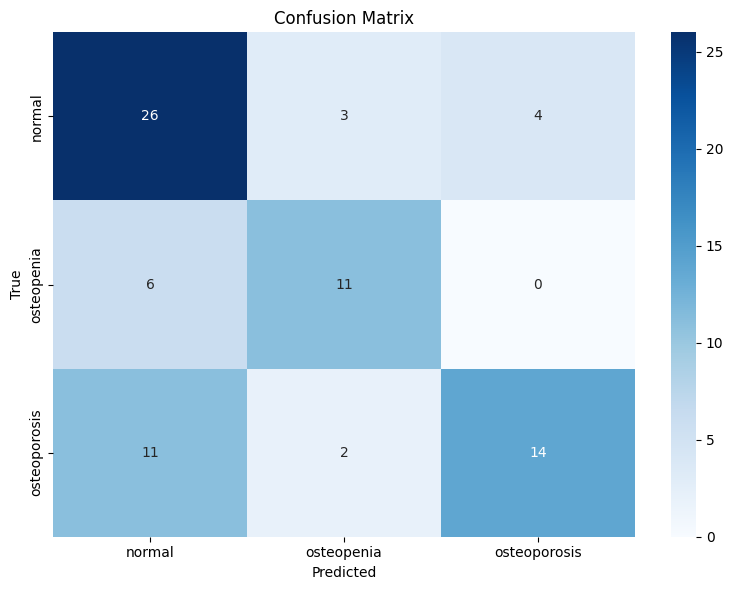

In [140]:
auc,f1,acc,cm = evaluate_predictions(true_labels, predicted_labels, all_probs, class_names)


In [141]:
wandb.log(
        {
            f"test_acc": acc,
            f"test_f1": f1,
            f"test_auc": auc if auc is not None else 0.0,
        }
    )

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - enseble")
wandb.log({f"enseble_confusion_matrix": wandb.Image(plt)})
plt.close()

# # Classification Report + Per-Class Metrics
# report = classification_report(
#     all_labels_np, all_preds_np, output_dict=True, zero_division=0
# )
# wandb.log(
#     {f"{model_name}_classification_report": report}
# )  # Log per-class metrics (optional)
# for label, metrics in report.items():
#     if isinstance(metrics, dict):
#         for metric_name, value in metrics.items():
#             wandb.log({f"{model_name}_{label}_{metric_name}": value})


In [142]:
from train.train import use_best_model_gideon
test_loader = DataLoader(
    test_dataset,
    batch_size=wandb.config.BATCH_SIZE,
    shuffle=False,
    num_workers=wandb.config.NUM_WORKERS,
)


# use_best_model_gideon(
#     models[0], "try", "saved_models/ens/dense/densenet121_best (1).pth", test_loader, criterion = nn.CrossEntropyLoss()

# )

In [143]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from collections import OrderedDict
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report
)
import wandb

def use_best_models_ensemble_gideon(
    models_list,  # list of tuples: [(model_obj, model_name, best_model_path), ...]
    test_loader,
    criterion
):
    # Load each model's best weights
    for model, model_name, best_model_path in models_list:
        artifact = wandb.Artifact(f"best_model_{model_name}", type="model")
        artifact.add_file(best_model_path)
        wandb.log_artifact(artifact)

        model.load_state_dict(torch.load(best_model_path, weights_only=False))
        model.eval()

    # Storage for evaluation
    all_labels = []
    all_probs_ensemble = []
    all_preds_ensemble = []
    all_images_path = []
    all_image_legs = []

    # remove previous logits file for ensemble
    run_tag = "ensemble_best"
    pt_prev = Path("saved_models") / f"{run_tag}_val_logits.pt"
    csv_prev = pt_prev.with_suffix(".csv")
    if pt_prev.exists():
        pt_prev.unlink()
    if csv_prev.exists():
        csv_prev.unlink()

    with torch.no_grad():
        for images, labels, images_path in test_loader:
            images = images.to(wandb.config.DEVICE)
            labels = labels.to(wandb.config.DEVICE)

            # --- Get predictions from all models ---
            probs_sum = None
            for model, _, _ in models_list:
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)

                if probs_sum is None:
                    probs_sum = probs
                else:
                    probs_sum += probs

            # Average probabilities
            probs_avg = probs_sum / len(models_list)
            _, predicted = torch.max(probs_avg.data, 1)

            # Track results
            all_labels.extend(labels.cpu().numpy())
            all_probs_ensemble.extend(probs_avg.cpu().numpy())
            all_preds_ensemble.extend(predicted.cpu().numpy())
            all_images_path.extend(
                [
                    os.path.splitext(os.path.basename(p))[0].split("_")[0]
                    for p in images_path
                ]
            )
            try:
                all_image_legs.extend(
                    [
                        os.path.splitext(os.path.basename(p))[0].split("_")[1]
                        for p in images_path
                    ]
                )
            except:
                all_image_legs.extend(["no_crop" for p in images_path])

    # Convert to numpy arrays
    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds_ensemble)
    all_probs_np = np.array(all_probs_ensemble)

    # --- Metrics ---
    avg_test_loss = None  # Not averaging losses in ensemble mode
    test_accuracy = (all_preds_np == all_labels_np).mean()
    test_f1 = f1_score(all_labels_np, all_preds_np, average="macro")
    test_precision = precision_score(all_labels_np, all_preds_np, average="macro")
    test_recall = recall_score(all_labels_np, all_preds_np, average="macro")
    try:
        all_labels_one_hot = np.eye(wandb.config.NUM_CLASSES)[all_labels_np]
        test_auc = roc_auc_score(
            all_labels_one_hot, all_probs_np, average="macro", multi_class="ovr"
        )
    except Exception as e:
        print(f"AUC computation failed: {e}")
        test_auc = None

    # --- Print summary ---
    print(
        f"[ENSEMBLE] Test Accuracy: {test_accuracy:.4f}, "
        f"F1: {test_f1:.4f}, Precision: {test_precision:.4f}, "
        f"Recall: {test_recall:.4f}, AUC: {test_auc if test_auc else 'N/A'}"
    )

    # --- Log to W&B ---
    wandb.log(
        {
            "ensemble_test_acc": test_accuracy,
            "ensemble_test_f1": test_f1,
            "ensemble_test_precision": test_precision,
            "ensemble_test_recall": test_recall,
            "ensemble_test_auc": test_auc if test_auc else 0.0,
        }
    )

    # --- Confusion Matrix ---
    if wandb.config.NUM_CLASSES == 2:
        class_names = ["Normal", "Osteoporosis"]
    else:
        class_names = ["Normal", "Osteopenia", "Osteoporosis"]

    cm = confusion_matrix(all_labels_np, all_preds_np)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - ENSEMBLE")
    wandb.log({"ensemble_confusion_matrix": wandb.Image(plt)})
    plt.show()


    # --- Classification Report ---
    report = classification_report(
        all_labels_np, all_preds_np, output_dict=True, zero_division=0
    )
    wandb.log({"ensemble_classification_report": report})
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric_name, value in metrics.items():
                wandb.log({f"ensemble_{label}_{metric_name}": value})

    # --- Optional: Merge with patient details ---
    if wandb.config.USE_METABOLIC_FOR_TEST:
        try:
            df_pred = pd.DataFrame(
                {
                    "labels": all_labels,
                    "preds": all_preds_ensemble,
                    "probs": all_probs_ensemble,
                    "path": all_images_path,
                    "leg_tag": all_image_legs,
                }
            )
            patient_details_path = "data/new_data/patient_details.csv"
            if os.path.exists(patient_details_path):
                df_patient = pd.read_csv(patient_details_path)
            else:
                print("Warning: Patient details file not found")
                df_patient = None

            if df_patient is not None:
                if "probs_class_0" not in df_patient.columns:
                    for c in range(wandb.config.NUM_CLASSES):
                        df_patient[f"probs_class_{c}"] = None

                df_merged = df_patient.reset_index().merge(
                    df_pred, left_on="Patient Id", right_on="path"
                )
                df_merged[
                    [f"probs_class_{i}" for i in range(wandb.config.NUM_CLASSES)]
                ] = pd.DataFrame(df_merged["probs"].tolist(), index=df_merged.index)

                output_csv_path = f"patient_details_with_probs_output_ensemble.csv"
                df_merged.to_csv(output_csv_path, index=False)

                artifact = wandb.Artifact("test_metabolic_ensemble", type="csv")
                artifact.add_file(output_csv_path)
                wandb.log_artifact(artifact)

        except Exception as e:
            print(f"Error processing patient details: {e}")


In [144]:
models_re=[
    # [models[0], "try", r"saved_models/ens/dense/densenet121_best (1).pth"],
    # [models[1], "try", r"saved_models/ens/dense/densenet121_best (2).pth"],
    [models[0], "try", r"saved_models/res/densenet121_best.pth"],

    [models[1], "try", r"saved_models/res/ResNet50_best (6).pth"]
           ]

[ENSEMBLE] Test Accuracy: 0.6494, F1: 0.6563, Precision: 0.6669, Recall: 0.6903, AUC: 0.8593168764291758


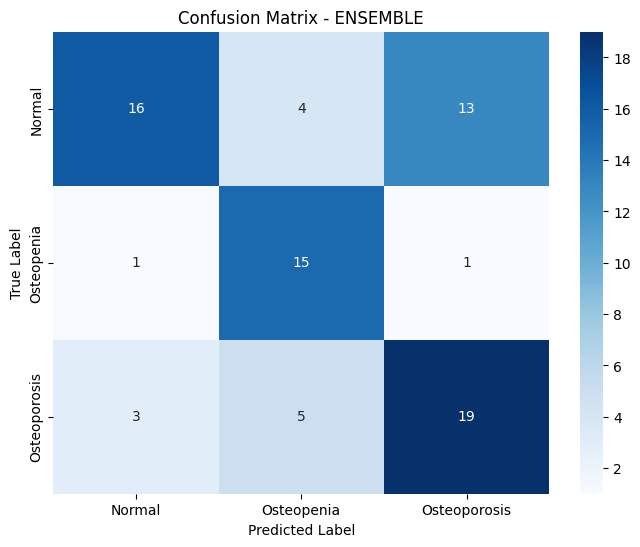

In [145]:
use_best_models_ensemble_gideon(
    models_re, test_loader, criterion = nn.CrossEntropyLoss()

)

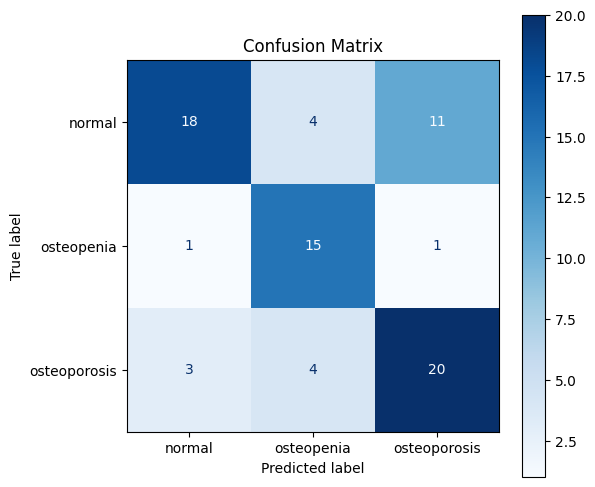

In [146]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device)  # first element: images
            labels = batch[1].to(device)  # second element: labels

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
    plt.title("Confusion Matrix")
    plt.show()

    return cm

# Example usage:
# Assuming your model is `model` and test dataloader is `test_loader`
# class_names = ['data-normal', 'osteopenia', 'osteoporosis']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cm = plot_confusion_matrix(models[0], test_loader, device, class_names)


In [147]:
class_names

['normal', 'osteopenia', 'osteoporosis']